# Alignment & Operatrions

This is more about *understanding* pandas, "going with the flow", than any particular operation. Alignment is a key part of many parts of pandas, including

- binary operations (`+, -, *, /, **, ==, |, &`)
- merges / joins / concats
- constructors
- reindexing

That said, it's not really something you'll be doing explicitly. It happens in the background, as part of all those tasks.
It's all about using *labels* (`DataFrame.index` and `DataFrame.columns`) to do the tricky work of making sure the operation goes through correctly.
You'll want an understanding of what's happening behind the scenes though, to help you understand pandas code you didn't write (or wrote a while ago).

If you thing you have a handle on this, jump down to the exercise at the end of the notebook.

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import side_by_side
from IPython import display

pd.options.display.max_rows = 10
sns.set(style='white', context='talk')

Let's start out doing things the "wrong" way. We've got data on GDP (total output each quarter) and CPI (a measure of inflation). Each CSV has a column of dates, and a column for the measurement.

In [7]:
!head data/cpi.csv

DATE,CPIAUCSL
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.0
1947-04-01,22.0
1947-05-01,21.95
1947-06-01,22.08
1947-07-01,22.23
1947-08-01,22.4
1947-09-01,22.84


In [39]:
# The "wrong" way
# Read in CPI & GDP, parsing the dates
gdp_bad = pd.read_csv("data/gdp.csv", parse_dates=['DATE'])
cpi_bad = pd.read_csv("data/cpi.csv", parse_dates=['DATE'])

In [41]:
gdp_bad.head()

,DATE,GDP
0,1947-01-01,243.1
1,1947-04-01,246.3
2,1947-07-01,250.1
3,1947-10-01,260.3
4,1948-01-01,266.2


In [42]:
cpi_bad.head()

,DATE,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


Typically, we would use `DATE` as the index (`index_col='DATE'` in `read_csv`). But to appreciate the value of labels, we'll take them away for now.

Real GDP is [defined to be](https://en.wikipedia.org/wiki/Real_gross_domestic_product) nominal GDP (which is what our `gdp` DataFrame contains) divided by a measure of the *price index*. Typically you'd use the GDP deflator, but we'll use CPI so that I can make a point later.

To calculate real GDP, divide `gdp` by `cpi`.
Notice that `gdp` is quarterly, and `cpi` is monthly, so we need to align the two.
Since we don't have meaningful row labels, we have to do it manually.
We'll find the dates in common between the two series, manually filter to those, and then do the division.

In [43]:
# merge on DATE, divide
m = pd.merge(gdp_bad, cpi_bad, on='DATE', how='inner')
m.head()

,DATE,GDP,CPIAUCSL
0,1947-01-01,243.1,21.48
1,1947-04-01,246.3,22.00
2,1947-07-01,250.1,22.23
3,1947-10-01,260.3,22.91
4,1948-01-01,266.2,23.68


In [44]:
m['GDP'] / m['CPIAUCSL']

0      11.317505
1      11.195455
2      11.250562
3      11.361851
4      11.241554
         ...    
264    71.124715
265    71.343420
266    71.962930
267    72.711603
268    72.313495
dtype: float64

In [26]:
%load solutions/alignment_02.py

That method is OK, but could be better,

1. The output has lost the `DATE` fields, we would need to manually bring those alogn after doing the division
2. We had to worry about doing the merge / alignment on data, which is incidental to the problem of calculating real gdp

## The Better Way

Pandas will handle all the fiddly details for alignment for us.

In [93]:
# use .squeeze to convert a 1 column df to a Series
gdp = pd.read_csv('data/gdp.csv', index_col='DATE', parse_dates=['DATE']).squeeze()
gdp.head()

DATE
1947-01-01    243.1
1947-04-01    246.3
1947-07-01    250.1
1947-10-01    260.3
1948-01-01    266.2
Name: GDP, dtype: float64

In [94]:
cpi = pd.read_csv('data/cpi.csv', index_col='DATE', parse_dates=['DATE']).squeeze()
cpi.head()

DATE
1947-01-01    21.48
1947-02-01    21.62
1947-03-01    22.00
1947-04-01    22.00
1947-05-01    21.95
Name: CPIAUCSL, dtype: float64

Now when you do the division, pandas will handle the alignemnt.

In [95]:
rgdp = gdp / cpi
rgdp

DATE
1947-01-01    11.317505
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.195455
1947-05-01          NaN
                ...    
2015-01-01          NaN
2015-02-01          NaN
2015-03-01          NaN
2015-04-01          NaN
2015-05-01          NaN
dtype: float64

You'll notice that a bunch of the values are `NaN`, short for ["Not A Number"](https://en.wikipedia.org/wiki/NaN).
This is the missing value indicator pandas uses for numeric data.

If you look closer, you'll see that there are valid values where the two Series had a common index (the first month of each quarter), and `NaN`s everywhere else.
Binary operations like `/`, `+`, ... align by label, inserting `NaN`s where necessary, and then proceed.

In [96]:
l, r = gdp.align(cpi)
side_by_side(l.head(), r.head())

`.align` will take the *union* (in the set-theory sense) of the indexes of the two arguments (`gdp` and `cpi`), and then *reindex* them by that unioned index.
`reindex`ing is an important concept in pandas.
The basic idea is to conform an original `Series` / `DataFrame` to a new `Index`

In [97]:
full_idx = gdp.index | cpi.index  # | is set union on Index
full_idx

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-06-01', '1947-07-01', '1947-08-01',
               '1947-09-01', '1947-10-01',
               ...
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01'],
              dtype='datetime64[ns]', name='DATE', length=821, freq=None)

In [98]:
gdp.reindex(full_idx)

DATE
1947-01-01    243.1
1947-02-01      NaN
1947-03-01      NaN
1947-04-01    246.3
1947-05-01      NaN
              ...  
2015-01-01      NaN
2015-02-01      NaN
2015-03-01      NaN
2015-04-01      NaN
2015-05-01      NaN
Name: GDP, dtype: float64

Ocassionally, you will do a manual `reindex`, but most of the time it's done in the background when you do an operation.
You shouldn't ever need to manually use `.align`, but it is useful to understand what pandas is doing for you.

### Aside: Handling Missing Data

Pandas, recognizing that missing data is a fact of life, has a bunch of methods for detecting handling missing data.

In [99]:
# detect with `isnull` and `notnull`

In [100]:
rgdp.isnull().head()

DATE
1947-01-01    False
1947-02-01     True
1947-03-01     True
1947-04-01    False
1947-05-01     True
dtype: bool

In [101]:
rgdp.notnull().head()

DATE
1947-01-01     True
1947-02-01    False
1947-03-01    False
1947-04-01     True
1947-05-01    False
dtype: bool

These are often useful as masks for boolean indexing:

In [102]:
rgdp[rgdp.notnull()].head()

DATE
1947-01-01    11.317505
1947-04-01    11.195455
1947-07-01    11.250562
1947-10-01    11.361851
1948-01-01    11.241554
dtype: float64

You can drop missing values with `.dropna`

In [103]:
rgdp.dropna()

DATE
1947-01-01    11.317505
1947-04-01    11.195455
1947-07-01    11.250562
1947-10-01    11.361851
1948-01-01    11.241554
                ...    
2013-01-01    71.124715
2013-04-01    71.343420
2013-07-01    71.962930
2013-10-01    72.711603
2014-01-01    72.313495
dtype: float64

Almost all pandas methods return a new Series or DataFrame, and do not mutate data inplace.

In [104]:
rgdp.head()

DATE
1947-01-01    11.317505
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.195455
1947-05-01          NaN
dtype: float64

To make the change stick, you can assign the output to a new variable (or re-assign it to `rgdp`.

There's also `fillna` to fill missing values, either with a value (which can be a scalar or array) or a method like `ffill` to fill-foward the last-observed value.

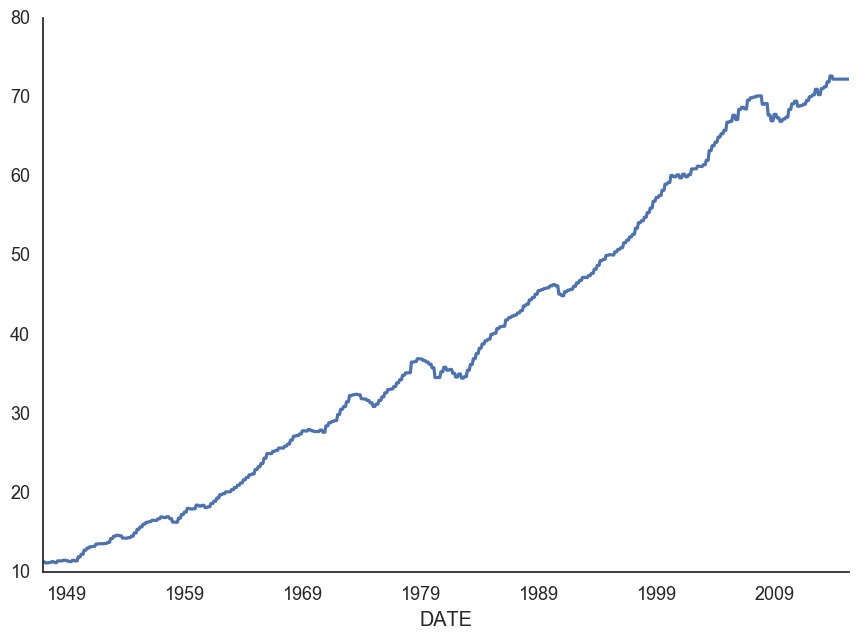

In [106]:
rgdp.fillna(method='ffill').plot()
sns.despine()

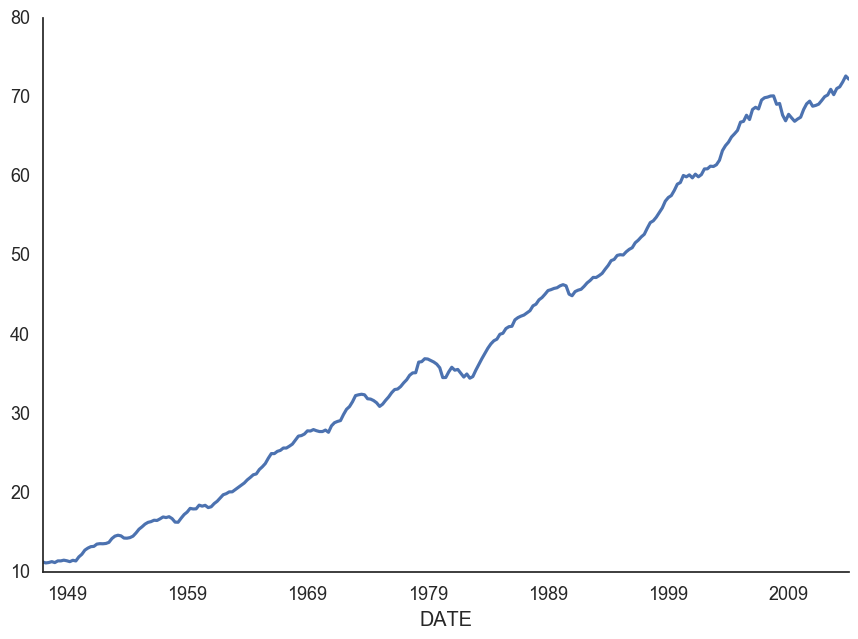

In [107]:
rgdp.dropna().plot()
sns.despine();

In [130]:
cpi.loc['1982':'1984']

100.01666666666667

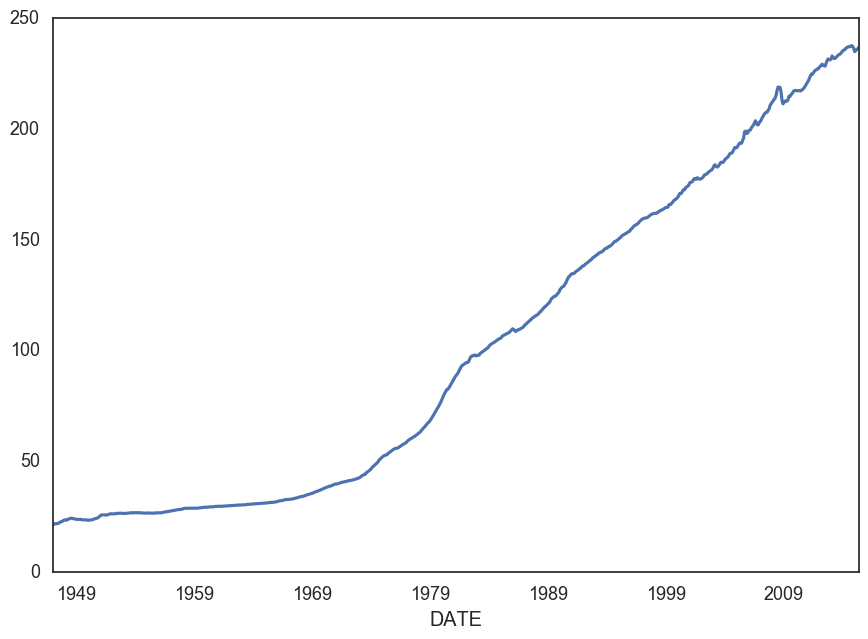

In [112]:
cpi.plot()

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

You'll hear real GDP reported in '2009 dollars', or '2005 dollars'.
The deflator (CPI in our case) is an index, and doesn't really have units.
Some time span is chosen to be the base and set equal to 100. Every other observation is relative to it.

For the exercise, compute real-gdp in 2009 dollars.

- Step 1: Convert CPI from base 1982-1984, to base 2009; Create a new series `cpi09` where the average value for 2009 is 100
- Step 2: Divide `gdp` by the result from Step 1
- Hint: Use [partial string indexing](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#datetimeindex-partial-string-indexing) to slice the values for just 2009

In [139]:
cpi09 = cpi / cpi.loc['2009'].mean() * 100
(gdp / cpi09).dropna()

DATE
1947-01-01     24.283366
1947-04-01     24.021490
1947-07-01     24.139732
1947-10-01     24.378517
1948-01-01     24.120403
                 ...    
2013-01-01    152.608507
2013-04-01    153.077771
2013-07-01    154.407021
2013-10-01    156.013408
2014-01-01    155.159209
dtype: float64

## Joining Pandas Objects

You'll run into problems where you have multiple `Series` or `DataFrame`s, that you want to join into a single `DataFrame`.
We saw an example of this earlier, but let's follow it up as a pair of exercises.

There are two main waits to do this

1. `pd.merge`: SQL-style joins
2. `pd.concat`: array-style joins

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Use [`pd.merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.merge.html) to join the two DataFrames `gdp_bad` and `cpi_bad`, using an *outer* join (earlier we used an *inner* join).

- Hint: You may want to sort by date afterward (see [`DataFrame.sort_values`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html))

In [140]:
# TODO: solution
pd.merge(gdp_bad, cpi_bad, on="DATE", how='outer').sort_values("DATE")

,DATE,GDP,CPIAUCSL
0,1947-01-01,243.1,21.480
269,1947-02-01,NaN,21.620
270,1947-03-01,NaN,22.000
1,1947-04-01,246.3,22.000
271,1947-05-01,NaN,21.950
...,...,...,...
816,2015-01-01,NaN,234.954
817,2015-02-01,NaN,235.415
818,2015-03-01,NaN,235.859
819,2015-04-01,NaN,236.197


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Use `concat` to stick together `gdp` and `cpi` into a DataFrame

In [141]:
# TODO: followup on merge now that we've discussed alignemnt,
# expand concat

In [142]:
# TODO: Solution
pd.concat([gdp, cpi], axis='columns')

,GDP,CPIAUCSL
DATE,,
1947-01-01,243.1,21.480
1947-02-01,NaN,21.620
1947-03-01,NaN,22.000
1947-04-01,246.3,22.000
1947-05-01,NaN,21.950
...,...,...
2015-01-01,NaN,234.954
2015-02-01,NaN,235.415
2015-03-01,NaN,235.859


When to use `merge` vs. `concat`?
My general rule is to use `concat` when you have two or more Series/DataFrames with an already aligned index.
I use `pd.merge` when doing data-base style joins that could be one-to-one, one-to-many, or many-to-many.

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>


During the housing bubble and financial crisis, [CalculatedRisk](http://www.calculatedriskblog.com) was one of the best places for information on the internet. Let's reproduce one of his charts:

In [143]:
display.Image(url='http://1.bp.blogspot.com/-Q60opady2iQ/VNoeGepLMWI/AAAAAAAAiQc/PCA1LfFJFCg/s1600/JOLTSDec2014.PNG')

This shows the components of turnover in the labor market. People leave jobs for two reasons:

1. Quits (light blue) or
2. Layoffs, discharges, or other (red).

Companies post job openings (yellow) and fill some number of those (Blue).
The difference between the openings and hires represents the change in the stock of open positions, and measures the slackness of the labor market.
The difference between the Hires and the sum of Quites and Layoffs / Discharges represents the change in the employed labor force (though the unemployment rate is calculated differently).

To get you started, the FRED series codes are

- JTSJOL: Openings
- JTSQUL: Quits
- JTSHIL: Hires
- JTSLDL: Layoffs

Use the `pandas_datareader.data.DataReader` class, which accepts a list of symbols, and a data_source (`'fred'`).
As a hint, you can use pandas' `.plot.area()` method for the Quits and Layoffs series. That handles all the stacking for you.

In [144]:
from pandas_datareader.data import DataReader

series = ['JTSJOL', 'JTSQUL', 'JTSHIL', 'JTSLDL']
names = ['openings', 'quits', 'hires', 'layoffs']

colors = {'quits': '#52b5ea', 'layoffs': '#d32c2c',
          'hires': '#2531db', 'openings': '#fffb49'}

area_colors = [colors['quits'], colors['layoffs']]
line_colors = [colors['hires'], colors['openings']]

In [145]:
# %load solutions/alignment_03.py


If you finish that, feel free to poke around [FRED](https://fred.stlouisfed.org) for more interesting series.

## Summary

Use alignment to make things easier on yourself.
Highlights one of the biggest difference between NumPy and pandas.
With NumPy, it was up to *you* to align things *by position*.
If you're deep in the middle of a complicated filtering and grouping
operation, you have to hope you haven't messed anything up. You could
easily end up in a situation where the output looks sensible, but has
been misaligned.